# SLC

## Imports

In [1]:
import os
import gc
import math
import time
import spectral
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,recall_score,cohen_kappa_score,accuracy_score
from torchmetrics.classification import MulticlassConfusionMatrix
from torchinfo import summary
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from pytorch_wavelets import DWTForward
from tqdm import tqdm
import random
#from torchviz import make_dot
#import h5py
import gc
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors


import hypso
from hypso import Hypso1
from hypso import Hypso2
from hypso.load import load_l1a_nc_cube
from hypso.load import load_l1b_nc_cube
from hypso.load import load_l1c_nc_cube
from hypso.load import load_l1d_nc_cube
from hypso.write import write_l1b_nc_file
from hypso.write import write_l1c_nc_file
from hypso.write import write_l1d_nc_file
from hypso.spectral_analysis import get_closest_wavelength_index


from torch.utils.data import ConcatDataset
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

start_time = time.time() 

# Device
torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Is CUDA available?:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("Current CUDA device:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("CUDA is not available.")

print("Allocated GPU memory:", torch.cuda.memory_allocated())
print("Cached GPU memory:", torch.cuda.memory_reserved())


Is CUDA available?: True
Current CUDA device: 0
Device name: NVIDIA GeForce RTX 3080 Ti
Allocated GPU memory: 0
Cached GPU memory: 0


## Settings

In [ ]:
data_file = 'l1b'

N_PCA = 10        
TRAIN_SIZE = 0.8  
BATCH_SIZE = 32
EPOCH = 30        
LR = 0.0005       
WEIGHT_DECAY = 0.0001 
PATCH_SIZE = 16 
STRIDE = 8        
NUM_CLASS = 3      
VAL_EPOCH = 2          

VALIDATION_SIZE = 0.2

## Dataset

In [3]:
# raw_data_path = r'C:\Users\Philip Shahdadfar\Desktop\HYPSORAWDATA'
# radiance_data_path = r'C:\Users\Philip Shahdadfar\Desktop\HYPSORADIANCE'
# reflectance_data_path = r'C:\Users\Philip Shahdadfar\Desktop\HYPSOREFLECTANCE'
# # List of L1A files
# raw_data_files = [
#     'adriatic_2024-07-18T08-53-45Z-l1a.nc',
# #     'aegean_2024-08-22T08-41-46Z-l1a.nc',
# #     'aeronetgalata_2025-01-02T08-18-16Z-l1a.nc',
# #     'annapolis_2024-09-08T15-34-29Z-l1a.nc',
# #     'aquawatchplymouth_2025-03-04T10-37-14Z-l1a.nc',
# #     'barbados_2025-03-04T13-54-23Z-l1a.nc',
# #     'capetown_2024-11-30T08-25-39Z-l1a.nc',
# #     'casablanca_2024-11-19T10-27-26Z-l1a.nc',
# #     'dubai_2024-11-21T06-24-16Z-l1a.nc',
# #     'erie_2024-09-18T15-53-53Z-l1a.nc',
# #     'eurasianplate1_2024-12-30T08-20-49Z-l1a.nc',
# #     'eurasianplate3_2024-12-14T08-49-37Z-l1a.nc',
# #     'flindersIsland_2024-11-09T23-33-38Z-l1a.nc',
# #     'florida_2024-05-21T15-51-31Z-l1a.nc',
# #     'florida_2024-05-30T15-34-21Z-l1a.nc',
# #     'fredrikstad_2024-09-10T09-54-25Z-l1a.nc',
# #     'frohavetnorth_2024-06-15T10-48-13Z-l1a.nc',
# #     'greenbay_2024-10-01T16-22-32Z-l1a.nc',
# #     'grizzlybay_2024-07-18T18-20-54Z-l1a.nc',
# #     'hawkebay_2024-12-23T21-43-24Z-l1a.nc',
# #     'kakhovka_2024-11-24T07-57-14Z-l1a.nc',
# #     'kemigawa_2025-01-30T01-03-42Z-l1a.nc',
# #     'kemigawa_2025-02-27T01-02-47Z-l1a.nc',
# #     'kvaloya_2024-06-17T10-00-18Z-l1a.nc',
# #     'lagunaDeTerminos_2024-12-06T16-07-50Z-l1a.nc',
# #     'lakewinnipeg_2024-08-13T17-07-06Z-l1a.nc',
# #     'longisland3_2024-07-15T14-49-22Z-l1a.nc',
# #     'longisland_2024-06-25T14-52-40Z-l1a.nc',
# #     'longisland_2024-08-26T14-51-29Z-l1a.nc',
# #     'malpasdam_2025-02-27T23-12-04Z-l1a.nc',
# #     'marmara_2024-04-16T08-16-38Z-l1a.nc',
# #     'mvco_2025-03-02T14-55-47Z-l1a.nc',
# #     'nile_2024-11-02T07-51-59Z-l1a.nc',
# #     'plocan_2024-12-28T11-00-05Z-l1a.nc',
# #     'rogaland_2024-06-01T09-56-49Z-l1a.nc',
# #     'sanfrancisco_2024-05-23T18-12-14Z-l1a.nc',
# #     'sicilychannel_2024-12-28T09-23-44Z-l1a.nc',
# #     'solbergstrand_2024-07-08T09-39-39Z-l1a.nc',
# #     'tasmania_2024-12-04T23-39-49Z-l1a.nc',
# #     'tenerife_2025-01-17T11-17-36Z-l1a.nc',
# #     'trondheim_2024-09-11T09-27-22Z-l1a.nc',
# #     'trondheim_2024-09-11T11-00-43Z-l1a.nc',
# #     'trondheim_2024-09-14T09-42-48Z-l1a.nc',
# ]
# # Process each L1A file
# for filename in raw_data_files:
#     try:
#         # Full path for input L1A file
#         l1a_file_path = os.path.join(raw_data_path, filename)
#         # Process the L1A file exactly like your working example
#         satobj_h1 = Hypso1(path=l1a_file_path, verbose=True)
#         satobj_h1.generate_l1b_cube()
#         satobj_h1.generate_l1c_cube()
#         satobj_h1.generate_l1d_cube()
        
#         write_l1d_nc_file(satobj=satobj_h1, overwrite=True)
#         print(f":white_tick: Successfully created L1B file for: {filename}")
#     except Exception as e:
#         print(f":x: Error processing {filename}: {e}")

In [4]:
RANDOM_SEED=42

print(f'Number of bands utilized: {N_PCA}') 
print(f'Training size: {TRAIN_SIZE}') 
print(f'Epochs: {EPOCH}') 
print(f'Batch size: {BATCH_SIZE}') 
print(f'Patch size: {PATCH_SIZE}') 
print(f'Learning rate: {LR}') 
print(f'Weight decay: {WEIGHT_DECAY}') 



random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False



SAVE_PATH = f"results\\{data_file}"
if not os.path.isdir(SAVE_PATH):
    os.mkdir(SAVE_PATH)


raw_data_path = r'C:\Users\Philip Shahdadfar\Desktop\HYPSORAWDATA'
radiance_data_path = r'C:\Users\Philip Shahdadfar\Desktop\HYPSORADIANCE'
reflectance_data_path = r'C:\Users\Philip Shahdadfar\Desktop\HYPSOREFLECTANCE'
labels_path = r'C:\Users\Philip Shahdadfar\Desktop\HYPSOLABELS'




raw_data_files = [
    'adriatic_2024-07-18T08-53-45Z-l1a.nc',
    'aegean_2024-08-22T08-41-46Z-l1a.nc',
    'aeronetgalata_2025-01-02T08-18-16Z-l1a.nc',
    'annapolis_2024-09-08T15-34-29Z-l1a.nc',
    'aquawatchplymouth_2025-03-04T10-37-14Z-l1a.nc',
    'barbados_2025-03-04T13-54-23Z-l1a.nc',
    'capetown_2024-11-30T08-25-39Z-l1a.nc',
    'casablanca_2024-11-19T10-27-26Z-l1a.nc',
    'dubai_2024-11-21T06-24-16Z-l1a.nc',
    'erie_2024-09-18T15-53-53Z-l1a.nc',
    'eurasianplate1_2024-12-30T08-20-49Z-l1a.nc',
    'eurasianplate3_2024-12-14T08-49-37Z-l1a.nc',
    'flindersIsland_2024-11-09T23-33-38Z-l1a.nc',
    'florida_2024-05-21T15-51-31Z-l1a.nc',
    'florida_2024-05-30T15-34-21Z-l1a.nc',
    'fredrikstad_2024-09-10T09-54-25Z-l1a.nc',
    'frohavetnorth_2024-06-15T10-48-13Z-l1a.nc',
    'greenbay_2024-10-01T16-22-32Z-l1a.nc',
    'grizzlybay_2024-07-18T18-20-54Z-l1a.nc',
    'hawkebay_2024-12-23T21-43-24Z-l1a.nc',
    'kakhovka_2024-11-24T07-57-14Z-l1a.nc',
    'kemigawa_2025-01-30T01-03-42Z-l1a.nc',
    'kemigawa_2025-02-27T01-02-47Z-l1a.nc',
    'kvaloya_2024-06-17T10-00-18Z-l1a.nc',
    'lagunaDeTerminos_2024-12-06T16-07-50Z-l1a.nc',
    'lakewinnipeg_2024-08-13T17-07-06Z-l1a.nc',
    'longisland3_2024-07-15T14-49-22Z-l1a.nc',
    'longisland_2024-06-25T14-52-40Z-l1a.nc',
    'longisland_2024-08-26T14-51-29Z-l1a.nc',
    'malpasdam_2025-02-27T23-12-04Z-l1a.nc',
    'marmara_2024-04-16T08-16-38Z-l1a.nc',
    'mvco_2025-03-02T14-55-47Z-l1a.nc',
    'nile_2024-11-02T07-51-59Z-l1a.nc',
    'plocan_2024-12-28T11-00-05Z-l1a.nc',
    'rogaland_2024-06-01T09-56-49Z-l1a.nc',
    'sanfrancisco_2024-05-23T18-12-14Z-l1a.nc',
    'sicilychannel_2024-12-28T09-23-44Z-l1a.nc',
    'solbergstrand_2024-07-08T09-39-39Z-l1a.nc',
    'tasmania_2024-12-04T23-39-49Z-l1a.nc',
    'tenerife_2025-01-17T11-17-36Z-l1a.nc',
    'trondheim_2024-09-11T09-27-22Z-l1a.nc',
    'trondheim_2024-09-11T11-00-43Z-l1a.nc',
    'trondheim_2024-09-14T09-42-48Z-l1a.nc',
]

radiance_data_files = [
    'adriatic_2024-07-18T08-53-45Z-l1b.nc',
    'aegean_2024-08-22T08-41-46Z-l1b.nc',
    'aeronetgalata_2025-01-02T08-18-16Z-l1b.nc',
    'annapolis_2024-09-08T15-34-29Z-l1b.nc',
    'aquawatchplymouth_2025-03-04T10-37-14Z-l1b.nc',
    'barbados_2025-03-04T13-54-23Z-l1b.nc',
    'capetown_2024-11-30T08-25-39Z-l1b.nc',
    'casablanca_2024-11-19T10-27-26Z-l1b.nc',
    'dubai_2024-11-21T06-24-16Z-l1b.nc',
    'erie_2024-09-18T15-53-53Z-l1b.nc',
    'eurasianplate1_2024-12-30T08-20-49Z-l1b.nc',
    'eurasianplate3_2024-12-14T08-49-37Z-l1b.nc',
    'flindersIsland_2024-11-09T23-33-38Z-l1b.nc',
    'florida_2024-05-21T15-51-31Z-l1b.nc',
    'florida_2024-05-30T15-34-21Z-l1b.nc',
    'fredrikstad_2024-09-10T09-54-25Z-l1b.nc',
    'frohavetnorth_2024-06-15T10-48-13Z-l1b.nc',
    # 'greenbay_2024-10-01T16-22-32Z-l1b.nc',
    # 'grizzlybay_2024-07-18T18-20-54Z-l1b.nc',
    # 'hawkebay_2024-12-23T21-43-24Z-l1b.nc',
    # 'kakhovka_2024-11-24T07-57-14Z-l1b.nc',
    # 'kemigawa_2025-01-30T01-03-42Z-l1b.nc',
    # 'kemigawa_2025-02-27T01-02-47Z-l1b.nc',
    # 'kvaloya_2024-06-17T10-00-18Z-l1b.nc',
    # 'lagunaDeTerminos_2024-12-06T16-07-50Z-l1b.nc',
    # 'lakewinnipeg_2024-08-13T17-07-06Z-l1b.nc',
    # 'longisland3_2024-07-15T14-49-22Z-l1b.nc',
    # 'longisland_2024-06-25T14-52-40Z-l1b.nc',
    # 'longisland_2024-08-26T14-51-29Z-l1b.nc',
    # 'malpasdam_2025-02-27T23-12-04Z-l1b.nc',
    # 'marmara_2024-04-16T08-16-38Z-l1b.nc',
    # 'mvco_2025-03-02T14-55-47Z-l1b.nc',
    # 'nile_2024-11-02T07-51-59Z-l1b.nc',
    # 'plocan_2024-12-28T11-00-05Z-l1b.nc',
    # 'rogaland_2024-06-01T09-56-49Z-l1b.nc',
    # 'sanfrancisco_2024-05-23T18-12-14Z-l1b.nc',
    # 'sicilychannel_2024-12-28T09-23-44Z-l1b.nc',
    # 'solbergstrand_2024-07-08T09-39-39Z-l1b.nc',
    # 'tasmania_2024-12-04T23-39-49Z-l1b.nc',
    # 'tenerife_2025-01-17T11-17-36Z-l1b.nc',
    # 'trondheim_2024-09-11T09-27-22Z-l1b.nc',
    # 'trondheim_2024-09-11T11-00-43Z-l1b.nc',
    # 'trondheim_2024-09-14T09-42-48Z-l1b.nc',
]

reflectance_data_files = [
    'adriatic_2024-07-18T08-53-45Z-l1d.nc',
    # 'aegean_2024-08-22T08-41-46Z-l1d.nc',
    # 'aeronetgalata_2025-01-02T08-18-16Z-l1d.nc',
    # 'annapolis_2024-09-08T15-34-29Z-l1d.nc',
    # 'aquawatchplymouth_2025-03-04T10-37-14Z-l1d.nc',
    # 'barbados_2025-03-04T13-54-23Z-l1d.nc',
    # 'capetown_2024-11-30T08-25-39Z-l1d.nc',
    # 'casablanca_2024-11-19T10-27-26Z-l1d.nc',
    # 'dubai_2024-11-21T06-24-16Z-l1d.nc',
    # 'erie_2024-09-18T15-53-53Z-l1d.nc',
    # 'eurasianplate1_2024-12-30T08-20-49Z-l1d.nc',
    # 'eurasianplate3_2024-12-14T08-49-37Z-l1d.nc',
    # 'flindersIsland_2024-11-09T23-33-38Z-l1d.nc',
    # 'florida_2024-05-21T15-51-31Z-l1d.nc',
    # 'florida_2024-05-30T15-34-21Z-l1d.nc',
    # 'fredrikstad_2024-09-10T09-54-25Z-l1d.nc',
    # 'frohavetnorth_2024-06-15T10-48-13Z-l1d.nc',
    # 'greenbay_2024-10-01T16-22-32Z-l1d.nc',
    # 'grizzlybay_2024-07-18T18-20-54Z-l1d.nc',
    # 'hawkebay_2024-12-23T21-43-24Z-l1d.nc',
    # 'kakhovka_2024-11-24T07-57-14Z-l1d.nc',
    # 'kemigawa_2025-01-30T01-03-42Z-l1d.nc',
    # 'kemigawa_2025-02-27T01-02-47Z-l1d.nc',
    # 'kvaloya_2024-06-17T10-00-18Z-l1d.nc',
    # 'lagunaDeTerminos_2024-12-06T16-07-50Z-l1d.nc',
    # 'lakewinnipeg_2024-08-13T17-07-06Z-l1d.nc',
    # 'longisland3_2024-07-15T14-49-22Z-l1d.nc',
    # 'longisland_2024-06-25T14-52-40Z-l1d.nc',
    # 'longisland_2024-08-26T14-51-29Z-l1d.nc',
    # 'malpasdam_2025-02-27T23-12-04Z-l1d.nc',
    # 'marmara_2024-04-16T08-16-38Z-l1d.nc',
    # 'mvco_2025-03-02T14-55-47Z-l1d.nc',
    # 'nile_2024-11-02T07-51-59Z-l1d.nc',
    # 'plocan_2024-12-28T11-00-05Z-l1d.nc',
    # 'rogaland_2024-06-01T09-56-49Z-l1d.nc',
    # 'sanfrancisco_2024-05-23T18-12-14Z-l1d.nc',
    # 'sicilychannel_2024-12-28T09-23-44Z-l1d.nc',
    # 'solbergstrand_2024-07-08T09-39-39Z-l1d.nc',
    # 'tasmania_2024-12-04T23-39-49Z-l1d.nc',
    # 'tenerife_2025-01-17T11-17-36Z-l1d.nc',
    # 'trondheim_2024-09-11T09-27-22Z-l1d.nc',
    # 'trondheim_2024-09-11T11-00-43Z-l1d.nc',
    # 'trondheim_2024-09-14T09-42-48Z-l1d.nc',
]

labels_files = [
    'adriatic_2024-07-18T08-53-45Z-l1a_labels.dat',
    'aegean_2024-08-22T08-41-46Z-l1a_labels.dat',
    'aeronetgalata_2025-01-02T08-18-16Z-l1a_labels.dat',
    'annapolis_2024-09-08T15-34-29Z-l1a_labels.dat',
    'aquawatchplymouth_2025-03-04T10-37-14Z-l1a_labels.dat',
    'barbados_2025-03-04T13-54-23Z-l1a_labels.dat',
    'capetown_2024-11-30T08-25-39Z-l1a_labels.dat',
    'casablanca_2024-11-19T10-27-26Z-l1a_labels.dat',
    'dubai_2024-11-21T06-24-16Z-l1a_labels.dat',
    'erie_2024-09-18T15-53-53Z-l1a_labels.dat',
    'eurasianplate1_2024-12-30T08-20-49Z-l1a_labels.dat',
    'eurasianplate3_2024-12-14T08-49-37Z-l1a_labels.dat',
    'flindersIsland_2024-11-09T23-33-38Z-l1a_labels.dat',
    'florida_2024-05-21T15-51-31Z-l1a_labels.dat',
    'florida_2024-05-30T15-34-21Z-l1a_labels.dat',
    'fredrikstad_2024-09-10T09-54-25Z-l1a_labels.dat',
    'frohavetnorth_2024-06-15T10-48-13Z-l1a_labels.dat',
    # 'greenbay_2024-10-01T16-22-32Z-l1a_labels.dat',
    # 'grizzlybay_2024-07-18T18-20-54Z-l1a_labels.dat',
    # 'hawkebay_2024-12-23T21-43-24Z-l1a_labels.dat',
    # 'kakhovka_2024-11-24T07-57-14Z-l1a_labels.dat',
    # 'kemigawa_2025-01-30T01-03-42Z-l1a_labels.dat',
    # 'kemigawa_2025-02-27T01-02-47Z-l1a_labels.dat',
    # 'kvaloya_2024-06-17T10-00-18Z-l1a_labels.dat',
    # 'lagunaDeTerminos_2024-12-06T16-07-50Z-l1a_labels.dat',
    # 'lakewinnipeg_2024-08-13T17-07-06Z-l1a_labels.dat',
    # 'longisland3_2024-07-15T14-49-22Z-l1a_labels.dat',
    # 'longisland_2024-06-25T14-52-40Z-l1a_labels.dat',
    # 'longisland_2024-08-26T14-51-29Z-l1a_labels.dat',
    # 'malpasdam_2025-02-27T23-12-04Z-l1a_labels.dat',
    # 'marmara_2024-04-16T08-16-38Z-l1a_labels.dat',
    # 'mvco_2025-03-02T14-55-47Z-l1a_labels.dat',
    # 'nile_2024-11-02T07-51-59Z-l1a_labels.dat',
    # 'plocan_2024-12-28T11-00-05Z-l1a_labels.dat',
    # 'rogaland_2024-06-01T09-56-49Z-l1a_labels.dat',
    # 'sanfrancisco_2024-05-23T18-12-14Z-l1a_labels.dat',
    # 'sicilychannel_2024-12-28T09-23-44Z-l1a_labels.dat',
    # 'solbergstrand_2024-07-08T09-39-39Z-l1a_labels.dat',
    # 'tasmania_2024-12-04T23-39-49Z-l1a_labels.dat',
    # 'tenerife_2025-01-17T11-17-36Z-l1a_labels.dat',
    # 'trondheim_2024-09-11T09-27-22Z-l1a_labels.dat',
    # 'trondheim_2024-09-11T11-00-43Z-l1a_labels.dat',
    # 'trondheim_2024-09-14T09-42-48Z-l1a_labels.dat',
]

def load_data(files, path, load_function, data_type):
    data_list = []
    file_names_list = []  

    total_files = len(files)
    with tqdm(total=total_files, desc=f"Loading {data_type} data", unit="file") as pbar:
        for idx, filename in enumerate(files, start=1):
            file_path = os.path.join(path, filename)
            data = load_function(file_path)
            data_list.append(data)
            file_names_list.append(filename)  
            
            pbar.set_postfix_str(f"Capture {idx} / {total_files}")
            pbar.update(1)

    return data_list, file_names_list  


if data_file == 'l1a':
    l1a_files, l1a_filenames = load_data(raw_data_files, raw_data_path, load_l1a_nc_cube, "L1A")
elif data_file == 'l1b':
    l1b_files, l1b_filenames = load_data(radiance_data_files, radiance_data_path, load_l1b_nc_cube, "L1B")
elif data_file == 'l1d':
    l1d_files, l1d_filenames = load_data(reflectance_data_files, reflectance_data_path, load_l1d_nc_cube, "L1D")

# Load Labels and Keep Track of Filenames
labels = []
label_filenames = []
total_labels = len(labels_files)

with tqdm(total=total_labels, desc="Loading labels", unit="file") as pbar:
    for idx, filename in enumerate(labels_files, start=1):
        file_path = os.path.join(labels_path, filename)
        label = np.fromfile(file_path, dtype=np.uint8)
        label = label.reshape((598, 1092))
        labels.append(label)
        label_filenames.append(filename)  # Store filename

        pbar.set_postfix_str(f"Label {idx} / {total_labels}")
        pbar.update(1)

print(f"{data_file} data shape: {l1b_files[0].shape}")
print(f"Labels shape: {labels[0].shape}")
print(f"Filename: {l1b_filenames[0]}")
print(f"Labelname: {label_filenames[0]}")


Number of bands utilized: 10
Training size: 0.8
Epochs: 30
Batch size: 32
Patch size: 16
Learning rate: 0.0005
Weight decay: 0.0001


Loading labels: 100%|██████████| 17/17 [00:00<00:00, 1450.49file/s, Label 17 / 17]

l1b data shape: (598, 1092, 120)
Labels shape: (598, 1092)
Filename: adriatic_2024-07-18T08-53-45Z-l1b.nc
Labelname: adriatic_2024-07-18T08-53-45Z-l1a_labels.dat


## Plot Captures and Labels

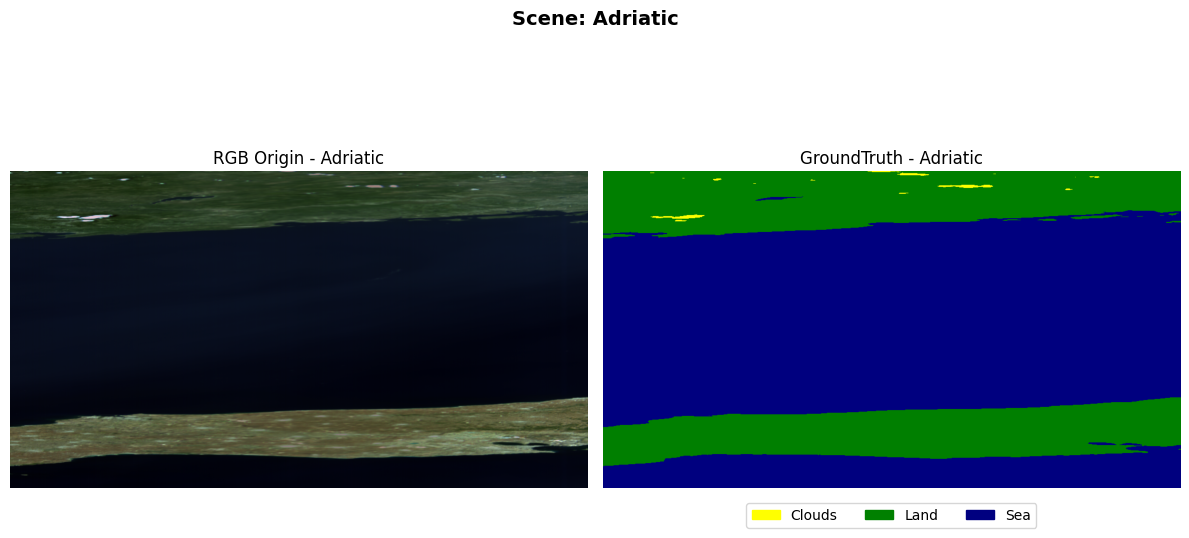

In [5]:
c1 = int(0)
#c1 = int(input("Select capture: "))
if data_file == 'l1a':
    hyperspectral_data = l1a_files[c1]
elif data_file == 'l1b':
    hyperspectral_data = l1b_files[c1]
elif data_file == 'l1d':
    hyperspectral_data = l1d_files[c1]
label = labels[c1]
scene_name = radiance_data_files[c1].split("_")[0]  



# class_names = { 1: "Snow", 2: "Land", 3: "Clouds", 4: "Sea"}  
# color_map = {
#     1: (1, 1, 1),        # Snow (white)
#     2: (0, 0.5, 0),      # Land (dark green)
#     3: (1, 1, 0),        # Clouds (yellow)
#     4: (0, 0, 0.5)       # Sea (dark blue)
# }

# Define class names and custom colormap
class_names = {1: "Clouds", 2: "Land", 3: "Sea"}
color_map = {
    1: (1, 1, 0),   # Clouds (yellow)
    2: (0, 0.5, 0), # Land (dark green)
    3: (0, 0, 0.5)  # Sea (dark blue)
}

# Convert color map dictionary into a ListedColormap
custom_cmap = mcolors.ListedColormap([color_map[i] for i in sorted(color_map.keys())])

# Create subplots (only 2 now)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Generate RGB image using specified bands
rgb_data = spectral.get_rgb(hyperspectral_data, (69, 46, 26))  

# Plot the original RGB image
axes[0].imshow(rgb_data)
axes[0].set_title(f'RGB Origin - {scene_name.capitalize()}')
axes[0].axis('off')

# Plot the ground truth labels with the custom colormap
im = axes[1].imshow(label, cmap=custom_cmap)
axes[1].set_title(f'GroundTruth - {scene_name.capitalize()}')
axes[1].axis('off')

# Extract unique labels present in the current label image
unique_labels = np.unique(label)

# Create legend with corresponding colors
patches = [
    mpatches.Patch(color=color_map[label_val], label=class_names.get(label_val, f"Class {label_val}"))
    for label_val in unique_labels
]

# Add legend below GroundTruth
axes[1].legend(handles=patches, loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=10)

# Set the scene name in the title
plt.suptitle(f'Scene: {scene_name.capitalize()}', fontsize=14, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit suptitle
plt.show()

## Pre-process data

### Dimensionality Reduction (PCA)

In [6]:
def applyPCA(X, numComponents):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)  
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca


def batch_pca_processing(files, selected_bands, num_pca_components, batch_size=4):
 
    pca_processed_images = []
    total_batches = math.ceil(len(files) / batch_size)
    
    with tqdm(total=len(files), desc="Processing PCA for images", unit="image") as pbar:
        for batch_idx in range(total_batches):
            start_idx = batch_idx * batch_size
            end_idx = min((batch_idx + 1) * batch_size, len(files))
            batch_files = files[start_idx:end_idx]
            
            batch_results = []
            for img in batch_files:
                # Extract only the selected bands
                filtered_data = img[:, :, selected_bands]
                
                # Flatten for PCA: Reshape to (pixels, bands)
                reshaped_data = filtered_data.reshape(-1, filtered_data.shape[-1])
                
                # Apply PCA
                pca = PCA(n_components=num_pca_components)
                pca_data = pca.fit_transform(reshaped_data)
                
                # Reshape back to (H, W, PCA components)
                pca_data = pca_data.reshape(img.shape[0], img.shape[1], num_pca_components)
                
                batch_results.append(pca_data)
                pbar.update(1)
            
            # Append batch results
            pca_processed_images.extend(batch_results)
            
            # Force garbage collection to free memory
            gc.collect()
            
    return np.array(pca_processed_images)




In [7]:
def extract_patches(image, patch_size=PATCH_SIZE, stride=STRIDE):
    if len(image.shape) == 2:  
        H, W = image.shape
        C = None
    else:  
        H, W, C = image.shape

    patches = []
    indices = []

    for i in range(0, H - patch_size + 1, stride):
        for j in range(0, W - patch_size + 1, stride):
            if C is None: 
                patch = image[i:i+patch_size, j:j+patch_size]  
            else:  
                patch = image[i:i+patch_size, j:j+patch_size, :]
            patches.append(patch)
            indices.append((i, j))

    return np.array(patches), indices

class PatchSet(Dataset):
    def __init__(self, images, labels=None, patch_size=PATCH_SIZE, stride=STRIDE, is_pred=False):
        self.images = images
        self.labels = labels
        self.patch_size = patch_size
        self.stride = stride
        self.is_pred = is_pred
        
        # Pre-calculate patch indices for each image
        self.patch_indices = []
        self.image_to_patch_map = []
        
        for img_idx, img in enumerate(images):
            h, w = img.shape[:2]
            img_patches = []
            
            for i in range(0, h - patch_size + 1, stride):
                for j in range(0, w - patch_size + 1, stride):
                    self.patch_indices.append((img_idx, i, j))
                    
        self.total_patches = len(self.patch_indices)
                    
    def __len__(self):
        return self.total_patches
    
    def __getitem__(self, idx):
        img_idx, i, j = self.patch_indices[idx]
        img = self.images[img_idx]
        patch_size = self.patch_size
        
        # Extract the patch only when needed
        if len(img.shape) == 2:
            patch = img[i:i+patch_size, j:j+patch_size]
            # Add channel dimension if grayscale
            patch = np.expand_dims(patch, axis=0)
        else:
            patch = img[i:i+patch_size, j:j+patch_size, :]
            # Move channels to first dimension (C, H, W)
            patch = np.transpose(patch, (2, 0, 1))
            
        # Convert only this patch to tensor
        patch_tensor = torch.tensor(patch, dtype=torch.float32)
        
        if not self.is_pred and self.labels is not None:
            label = self.labels[img_idx]
            label_patch = label[i:i+patch_size, j:j+patch_size]
            label_tensor = torch.tensor(label_patch, dtype=torch.long)
            return patch_tensor, label_tensor
        
        return patch_tensor
    
class TestPatchSet(Dataset):
    def __init__(self, images, patch_size=32, stride=16):
        self.images = images
        self.patch_size = patch_size
        self.stride = stride
        
        # Pre-calculate patch indices for each image
        self.patch_indices = []
        
        for img_idx, img in enumerate(images):
            h, w = img.shape[:2]
            
            for i in range(0, h - patch_size + 1, stride):
                for j in range(0, w - patch_size + 1, stride):
                    self.patch_indices.append((img_idx, i, j))
                    
    def __len__(self):
        return len(self.patch_indices)
    
    def __getitem__(self, idx):
        img_idx, i, j = self.patch_indices[idx]
        img = self.images[img_idx]
        patch_size = self.patch_size
        
        # Extract the patch only when needed
        if len(img.shape) == 2:
            patch = img[i:i+patch_size, j:j+patch_size]
            # Add channel dimension if grayscale
            patch = np.expand_dims(patch, axis=0)
        else:
            patch = img[i:i+patch_size, j:j+patch_size, :]
            # Move channels to first dimension (C, H, W)
            patch = np.transpose(patch, (2, 0, 1))
            
        # Convert only this patch to tensor
        patch_tensor = torch.tensor(patch, dtype=torch.float32)
        
        return patch_tensor, img_idx
    

def reconstruct_image(patches, original_shape, patch_size=PATCH_SIZE, stride=STRIDE):

    H, W = original_shape  # ✅ Ensure (H, W) only
    reconstructed = np.zeros((H, W), dtype=np.uint16)  # ✅ Use `uint16` to avoid overflow
    count = np.zeros((H, W), dtype=np.uint16)

    patch_idx = 0
    for i in range(0, H - patch_size + 1, stride):
        for j in range(0, W - patch_size + 1, stride):
            reconstructed[i:i+patch_size, j:j+patch_size] += patches[patch_idx].astype(np.uint16)  # ✅ Convert dtype
            count[i:i+patch_size, j:j+patch_size] += 1
            patch_idx += 1


    return (reconstructed / np.maximum(count, 1)).astype(np.uint8)

## Apply Transformations

In [8]:
# Selected spectral bands to use before PCA
selected_bands = [110, 109, 111, 108, 113, 112, 107, 102, 101, 100, 99, 106, 98, 103, 97, 96,
                            81, 80, 79, 78, 77, 76, 75, 74, 82, 85, 73, 86, 84, 95, 88, 87, 72, 89, 71,
                            70, 69, 90, 83, 68, 67, 93, 64, 66, 94, 65, 63, 62, 61, 60, 59, 9, 58, 91,
                            105, 57, 10, 54, 55, 56, 92, 53, 52, 51, 11, 12, 50, 49, 48, 47, 13, 46,
                            14, 6, 4, 45, 3, 5, 7, 34, 8, 15, 16, 25, 44, 33, 43, 35, 40, 36, 17, 41,
                            42, 37, 29, 39, 32, 38, 26, 20, 19, 18, 27, 28, 30, 24, 31, 21, 23, 22, 104]

num_pca_components = N_PCA


if data_file == 'l1a':
    files_to_process = l1a_files
elif data_file == 'l1b':
    files_to_process = l1b_files
elif data_file == 'l1d':
    files_to_process = l1d_files

# Process the selected files
pca_processed_images = batch_pca_processing(
    files=files_to_process,
    selected_bands=selected_bands,
    num_pca_components=num_pca_components,
    batch_size=BATCH_SIZE
)

print(f"Processed {data_file} shape: {pca_processed_images.shape}")





Processing PCA for images: 100%|██████████| 17/17 [00:12<00:00,  1.36image/s]


Processed l1b shape: (17, 598, 1092, 10)


## Data Split

In [9]:

processed_images = np.array(pca_processed_images)
print(f"Processed {data_file} shape: {processed_images.shape}")



# First split: training vs testing (exactly as you have it)
(training_files, testing_files, 
 training_labels, testing_labels, 
 training_filenames, testing_filenames, 
 training_label_filenames, testing_label_filenames) = train_test_split(
    processed_images, labels, l1b_filenames, label_filenames, 
    test_size=1 - TRAIN_SIZE, random_state=42
)



(train_images, val_images, 
 train_labels, val_labels, 
 train_filenames, val_filenames, 
 train_label_filenames, val_label_filenames) = train_test_split(
    training_files, training_labels, training_filenames, training_label_filenames,
    test_size=VALIDATION_SIZE, random_state=42
)

# Create datasets using your PatchSet classes (unchanged)
train_data = PatchSet(train_images, train_labels, PATCH_SIZE, STRIDE)
val_data = PatchSet(val_images, val_labels, PATCH_SIZE, STRIDE)
test_data = TestPatchSet(testing_files, PATCH_SIZE, STRIDE)

# Create data loaders (unchanged)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

print(f"✅ Training & validation DataLoaders ready. No memory overload!")

Processed l1b shape: (17, 598, 1092, 10)
✅ Training & validation DataLoaders ready. No memory overload!


## Create dataset and dataloader

In [10]:

train_data = PatchSet(train_images, train_labels, PATCH_SIZE, STRIDE)
val_data = PatchSet(val_images, val_labels, PATCH_SIZE, STRIDE)
test_data = TestPatchSet(testing_files, PATCH_SIZE, STRIDE)


train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

print(f"✅ Training & validation DataLoaders ready. No memory overload!")



✅ Training & validation DataLoaders ready. No memory overload!


## Model

In [11]:
class WaveletCNN(nn.Module):
    def __init__(self, in_channels, class_nums, levels=4):
        super(WaveletCNN, self).__init__()
        self.levels = levels
        
        # Wavelet transform layers
        self.dwt = nn.ModuleList([DWTForward(J=1, mode='zero', wave='db1') for _ in range(levels)])
        
        # Projection and convolution blocks with the same channel progression as the classification model
        self.projections = nn.ModuleList()
        self.conv_blocks = nn.ModuleList()
        
        for i in range(levels):
            # Keep the same channel calculation logic from the classification model
            input_channels = in_channels + 3 * in_channels + sum(64 * (j + 1) for j in range(i))
            output_channels = 64 * (i + 1)
            
            self.projections.append(nn.Conv2d(input_channels, output_channels, kernel_size=1))
            self.conv_blocks.append(nn.Sequential(
                nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
            ))
        
        # Replace global pooling and FC layer with segmentation head
        total_channels = sum(64 * (i + 1) for i in range(levels))
        self.seg_head = nn.Sequential(
            nn.Conv2d(total_channels, total_channels // 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(total_channels // 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(total_channels // 2, class_nums, kernel_size=1)
        )

    def forward(self, x):
        input_size = x.shape[2:]  # Store original input size
        features = []
        low_pass = x
        
        # Wavelet processing (same as before)
        for i in range(self.levels):
            low_pass, high_pass = self.dwt[i](low_pass)
            batch_size, channels, height, width = low_pass.shape
            _, high_pass_channels, subbands, _, _ = high_pass[0].shape
            high_pass = high_pass[0].view(batch_size, high_pass_channels * subbands, height, width)
            
            resized_features = [
                F.interpolate(feat, size=(height, width), mode='bilinear', align_corners=False)
                for feat in features
            ]
            
            concatenated = torch.cat([low_pass, high_pass] + resized_features, dim=1)
            projected = self.projections[i](concatenated)
            conv_out = self.conv_blocks[i](projected)
            features.append(conv_out)
        
        # Process features for segmentation
        smallest_height, smallest_width = features[-1].shape[2:]
        resized_features = [
            F.interpolate(feat, size=(smallest_height, smallest_width), mode='bilinear', align_corners=False)
            for feat in features
        ]
        
        out = torch.cat(resized_features, dim=1)
        out = self.seg_head(out)
        
        # Upscale back to input size for segmentation
        out = F.interpolate(out, size=input_size, mode='bilinear', align_corners=False)
        
        return out


In [12]:
# Initialize the model
net = WaveletCNN(in_channels=N_PCA, class_nums=NUM_CLASS)

# Input tensor
input_tensor = torch.randn(1, N_PCA, PATCH_SIZE, PATCH_SIZE)
print(f"Input tensor shape: {input_tensor.shape}")

# Model summary
summary(
    net,
    input_size=(1, N_PCA, PATCH_SIZE, PATCH_SIZE),
    col_names=['num_params', 'kernel_size', 'mult_adds', 'input_size', 'output_size'],
    col_width=18,
    row_settings=['var_names'],
    depth=4,
)



Input tensor shape: torch.Size([1, 10, 16, 16])


Layer (type (var_name))                  Param #            Kernel Shape       Mult-Adds          Input Shape        Output Shape
WaveletCNN (WaveletCNN)                  --                 --                 --                 [1, 10, 16, 16]    [1, 3, 16, 16]
├─ModuleList (dwt)                       --                 --                 --                 --                 --
│    └─DWTForward (0)                    --                 --                 --                 [1, 10, 16, 16]    [1, 10, 8, 8]
├─ModuleList (projections)               (recursive)        --                 --                 --                 --
│    └─Conv2d (0)                        2,624              [1, 1]             167,936            [1, 40, 8, 8]      [1, 64, 8, 8]
├─ModuleList (conv_blocks)               (recursive)        --                 --                 --                 --
│    └─Sequential (0)                    --                 --                 --                 [1, 64, 8, 8]     

## Training

Using device: cuda


Training::   3%|▎         | 1/30 [00:28<13:41, 28.32s/it]

epoch 0/30 loss:2.7069504364683774e-05  acc:0.9158753488077118


100%|██████████| 3080/3080 [00:27<00:00, 110.01it/s]


epoch 1/30 loss:1.9577622272560675e-05  acc:0.938060629122273


Training::   7%|▋         | 2/30 [01:03<15:04, 32.30s/it]

epoch 1/30  val_acc:0.714946674699814
Epoch 2/30 completed in 35.08 seconds.


Training::  10%|█         | 3/30 [01:31<13:37, 30.26s/it]

epoch 2/30 loss:1.8508518625811882e-05  acc:0.9401830844114663


100%|██████████| 3080/3080 [00:27<00:00, 110.60it/s]


epoch 3/30 loss:1.7556843577215473e-05  acc:0.9427223252790462


Training::  13%|█▎        | 4/30 [02:06<13:53, 32.05s/it]

epoch 3/30  val_acc:0.7082249915440555
Epoch 4/30 completed in 34.80 seconds.


Training::  17%|█▋        | 5/30 [02:33<12:43, 30.55s/it]

epoch 4/30 loss:1.7144045290357152e-05  acc:0.9432840642440385


100%|██████████| 3080/3080 [00:27<00:00, 110.20it/s]


epoch 5/30 loss:1.6896639195062516e-05  acc:0.943599576674277


Training::  20%|██        | 6/30 [03:08<12:48, 32.03s/it]

epoch 5/30  val_acc:0.723317663411128
Epoch 6/30 completed in 34.90 seconds.


Training::  23%|██▎       | 7/30 [03:36<11:45, 30.68s/it]

epoch 6/30 loss:1.6511656701060557e-05  acc:0.9449431205606291


100%|██████████| 3080/3080 [00:27<00:00, 110.20it/s]


epoch 7/30 loss:1.6437742303789795e-05  acc:0.9449676163749365


Training::  27%|██▋       | 8/30 [04:11<11:45, 32.05s/it]

epoch 7/30  val_acc:0.7359553367579909
Epoch 8/30 completed in 34.98 seconds.


Training::  30%|███       | 9/30 [04:39<10:46, 30.77s/it]

epoch 8/30 loss:1.6263743942593252e-05  acc:0.9449973443049213


100%|██████████| 3080/3080 [00:27<00:00, 110.66it/s]


epoch 9/30 loss:1.6012270026474073e-05  acc:0.9455813990360223


Training::  33%|███▎      | 10/30 [05:14<10:40, 32.00s/it]

epoch 9/30  val_acc:0.7549559762387958
Epoch 10/30 completed in 34.78 seconds.


Training::  37%|███▋      | 11/30 [05:42<09:43, 30.71s/it]

epoch 10/30 loss:1.5976533362954555e-05  acc:0.945791119672755


100%|██████████| 3080/3080 [00:27<00:00, 110.45it/s]


epoch 11/30 loss:1.5790088280137296e-05  acc:0.9460503472222223


Training::  40%|████      | 12/30 [06:17<09:35, 31.96s/it]

epoch 11/30  val_acc:0.7550088258921022
Epoch 12/30 completed in 34.81 seconds.


Training::  43%|████▎     | 13/30 [06:44<08:42, 30.74s/it]

epoch 12/30 loss:1.5860683853627382e-05  acc:0.9459030948756976


100%|██████████| 3080/3080 [00:27<00:00, 110.17it/s]


epoch 13/30 loss:1.5777347914858075e-05  acc:0.9462565401445967


Training::  47%|████▋     | 14/30 [07:19<08:32, 32.00s/it]

epoch 13/30  val_acc:0.7365095974970404
Epoch 14/30 completed in 34.93 seconds.


Training::  50%|█████     | 15/30 [07:47<07:41, 30.76s/it]

epoch 14/30 loss:1.5641118515605094e-05  acc:0.9462958999238965


100%|██████████| 3080/3080 [00:27<00:00, 110.66it/s]


epoch 15/30 loss:1.560579917807162e-05  acc:0.9463240820015221


Training::  53%|█████▎    | 16/30 [08:22<07:27, 31.99s/it]

epoch 15/30  val_acc:0.7123222930407577
Epoch 16/30 completed in 34.82 seconds.


Training::  57%|█████▋    | 17/30 [08:50<06:39, 30.74s/it]

epoch 16/30 loss:1.5524020395083682e-05  acc:0.9465656313419584


100%|██████████| 3080/3080 [00:27<00:00, 110.71it/s]


epoch 17/30 loss:1.556723436463041e-05  acc:0.9464993182394723


Training::  60%|██████    | 18/30 [09:25<06:23, 31.96s/it]

epoch 17/30  val_acc:0.7872132906308135
Epoch 18/30 completed in 34.82 seconds.


Training::  63%|██████▎   | 19/30 [09:53<05:37, 30.72s/it]

epoch 18/30 loss:1.5495984126536228e-05  acc:0.9467638175418569


100%|██████████| 3080/3080 [00:27<00:00, 110.69it/s]


epoch 19/30 loss:1.5469104297916753e-05  acc:0.9465835870116692


Training::  67%|██████▋   | 20/30 [10:27<05:19, 31.94s/it]

epoch 19/30  val_acc:0.7488717920260443
Epoch 20/30 completed in 34.79 seconds.


Training::  70%|███████   | 21/30 [10:55<04:36, 30.71s/it]

epoch 20/30 loss:1.5384058988044054e-05  acc:0.9468147117579908


100%|██████████| 3080/3080 [00:27<00:00, 110.67it/s]


epoch 21/30 loss:1.542203279528088e-05  acc:0.9467874809741248


Training::  73%|███████▎  | 22/30 [11:30<04:15, 31.97s/it]

epoch 21/30  val_acc:0.7626409764501945
Epoch 22/30 completed in 34.90 seconds.


Training::  77%|███████▋  | 23/30 [11:58<03:35, 30.73s/it]

epoch 22/30 loss:1.5396553467153116e-05  acc:0.9467929905504819


100%|██████████| 3080/3080 [00:27<00:00, 110.52it/s]


epoch 23/30 loss:1.5303983705964155e-05  acc:0.9471805238457636


Training::  80%|████████  | 24/30 [12:33<03:11, 31.95s/it]

epoch 23/30  val_acc:0.751749455648571
Epoch 24/30 completed in 34.80 seconds.


Training::  83%|████████▎ | 25/30 [13:01<02:33, 30.75s/it]

epoch 24/30 loss:1.5319648606894112e-05  acc:0.9468981877853881


100%|██████████| 3080/3080 [00:27<00:00, 110.52it/s]


epoch 25/30 loss:1.5317460965390688e-05  acc:0.9469898290842212


Training::  87%|████████▋ | 26/30 [13:36<02:07, 32.00s/it]

epoch 25/30  val_acc:0.7447263973448334
Epoch 26/30 completed in 34.90 seconds.


Training::  90%|█████████ | 27/30 [14:04<01:32, 30.77s/it]

epoch 26/30 loss:1.5331047375449754e-05  acc:0.9469738156392694


100%|██████████| 3080/3080 [00:27<00:00, 110.67it/s]


epoch 27/30 loss:1.5392562106897525e-05  acc:0.9468157423262303


Training::  93%|█████████▎| 28/30 [14:38<01:03, 31.96s/it]

epoch 27/30  val_acc:0.7379582064941654
Epoch 28/30 completed in 34.75 seconds.


Training::  97%|█████████▋| 29/30 [15:06<00:30, 30.75s/it]

epoch 28/30 loss:1.5301287377973816e-05  acc:0.9470835315195333


100%|██████████| 3080/3080 [00:28<00:00, 109.65it/s]


epoch 29/30 loss:1.5246135478722685e-05  acc:0.9469474965119229


Training:: 100%|██████████| 30/30 [15:41<00:00, 31.39s/it]


epoch 29/30  val_acc:0.7180799985202098
Epoch 30/30 completed in 35.11 seconds.
Training completed in 941.79 seconds.
Stop in epoch 29


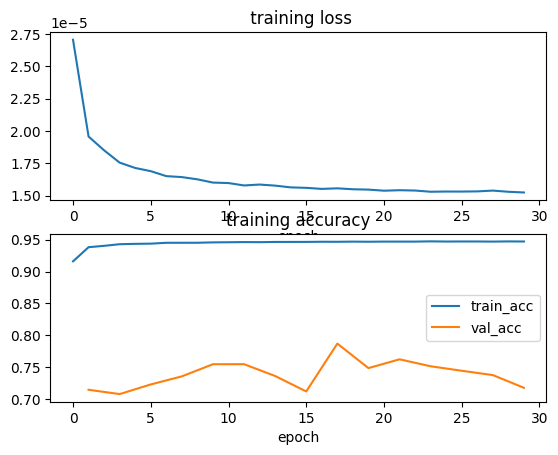

In [13]:


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(DEVICE)
print(f"Using device: {device}")
loss_list = []
acc_list = []
val_acc_list = []
val_epoch_list = []

model = WaveletCNN(N_PCA, class_nums=NUM_CLASS)
model.to(device)
#optimizer = torch.optim.SGD(model.parameters(), LR,weight_decay=WEIGHT_DECAY)
optimizer = torch.optim.Adam(model.parameters(),LR,weight_decay=WEIGHT_DECAY)
loss_func = nn.CrossEntropyLoss()
batch_num = len(train_loader)
train_num = train_loader.dataset.__len__()*PATCH_SIZE*PATCH_SIZE
val_num = val_loader.dataset.__len__()*PATCH_SIZE*PATCH_SIZE

fig = plt.figure()
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

e = -1


start_time = time.time()

try:
    for e in tqdm(range(EPOCH), desc="Training:"):
        epoch_start_time = time.time()
        model.train()
        avg_loss = 0.
        train_acc = 0
        for batch_idx, (data, target) in tqdm(enumerate(train_loader),total=batch_num):
            data,target = data.to(device),target.to(device)
            optimizer.zero_grad()
            out = model(data)
            target = target - 1  ## class 0 in out is class 1 in target
            loss = loss_func(out,target)
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            _,pred = torch.max(out,dim=1)
            train_acc += (pred == target).sum().item()
        loss_list.append(avg_loss/train_num)
        acc_list.append(train_acc/train_num)
        print(f"epoch {e}/{EPOCH} loss:{loss_list[e]}  acc:{acc_list[e]}")
        ## valuation
        if (e+1)%VAL_EPOCH == 0 or (e+1)==EPOCH:
            val_acc =0
            model.eval()
            for batch_idx, (data, target) in tqdm(enumerate(val_loader),total=len(val_loader)):
                data,target = data.to(device),target.to(device)
                out = model(data)
                target = target - 1  ## class 0 in out is class 1 in target
                _,pred = torch.max(out,dim=1)
                val_acc += (pred == target).sum().item()
            val_acc_list.append(val_acc/val_num)
            val_epoch_list.append(e)
            print(f"epoch {e}/{EPOCH}  val_acc:{val_acc_list[-1]}")
            save_name = os.path.join(SAVE_PATH, f"epoch_{e}_acc_{val_acc_list[-1]:.4f}.pth")
            torch.save(model.state_dict(),save_name)


            epoch_end_time = time.time()
            print(f"Epoch {e + 1}/{EPOCH} completed in {epoch_end_time - epoch_start_time:.2f} seconds.")



    ax1.plot(np.arange(e+1),loss_list)
    ax1.set_title(' training loss')
    ax1.set_xlabel('epoch')
    ax2.plot(np.arange(e+1),acc_list,label = 'train_acc')
    ax2.plot(val_epoch_list,val_acc_list,label = 'val_acc')
    ax2.set_title('training accuracy')
    ax2.set_xlabel('epoch')
    ax2.legend()
except Exception as exc:
    print(exc)
finally: 
    total_time = time.time() - start_time
    print(f"Training completed in {total_time:.2f} seconds.")
    print(f'Stop in epoch {e}')

### Save Best Model

In [17]:
## get best model path and del other models
def get_best_model(acc_list, epoch_list, save_path):
    acc_list = np.array(acc_list)
    epoch_list = np.array(epoch_list)
    best_index = np.argwhere(acc_list==np.max(acc_list))[-1].item()
    best_epoch = epoch_list[best_index]
    best_acc = acc_list[best_index]
    file_name = f"epoch_{best_epoch}_acc_{best_acc:.4f}.pth"
    best_model_path=os.path.join(save_path, file_name)
    print(f"best model:{file_name}")
    ##del save model except best model
    for f in os.listdir(save_path):
        if f[-3:]=='pth' and os.path.join(save_path,f)!=best_model_path:
            os.remove(os.path.join(save_path,f))
    return best_model_path

### Load

C:\Users\Philip Shahdadfar\AppData\Local\Temp\ipykernel_20460\2604847882.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_mode

best model:epoch_17_acc_0.7872.pth
✅ Loading Best Model from: results\l1b\epoch_17_acc_0.7872.pth
✅ Model loaded successfully. Ready for inference!

Processing Test Image 1/4 - Scene: adriatic_2024-07-18T08-53-45Z
Unique classes in ground truth before plotting: [1 2 3]


Predicting Image 1: 100%|██████████| 19/19 [00:01<00:00, 15.85it/s]


Unique classes in prediction before plotting: [0 1 2]


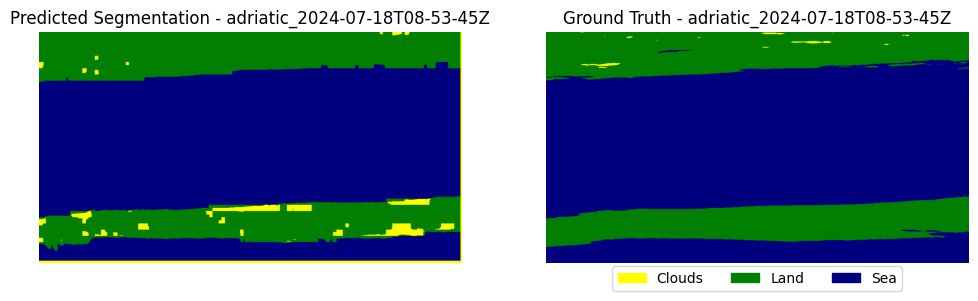


Processing Test Image 2/4 - Scene: aegean_2024-08-22T08-41-46Z
Unique classes in ground truth before plotting: [1 2 3]


Predicting Image 2: 100%|██████████| 19/19 [00:00<00:00, 21.11it/s]


Unique classes in prediction before plotting: [0 1 2]


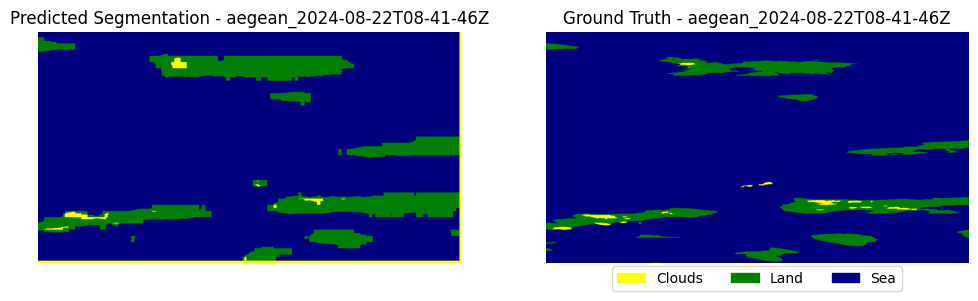


Processing Test Image 3/4 - Scene: barbados_2025-03-04T13-54-23Z
Unique classes in ground truth before plotting: [1 2 3]


Predicting Image 3: 100%|██████████| 19/19 [00:00<00:00, 21.17it/s]


Unique classes in prediction before plotting: [0 1 2]


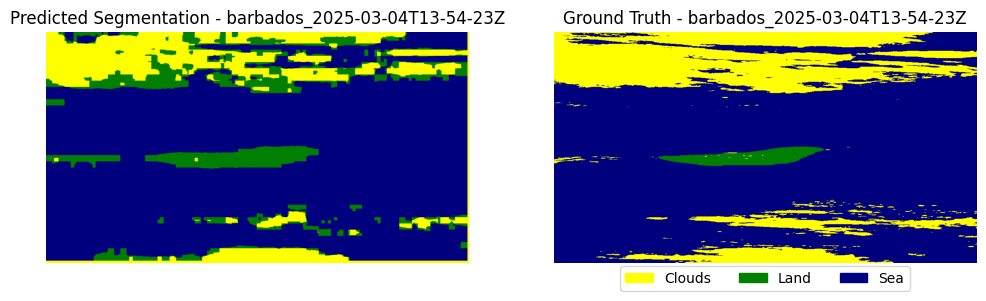


Processing Test Image 4/4 - Scene: fredrikstad_2024-09-10T09-54-25Z
Unique classes in ground truth before plotting: [1 2 3]


Predicting Image 4: 100%|██████████| 19/19 [00:00<00:00, 21.27it/s]


Unique classes in prediction before plotting: [0 1 2]


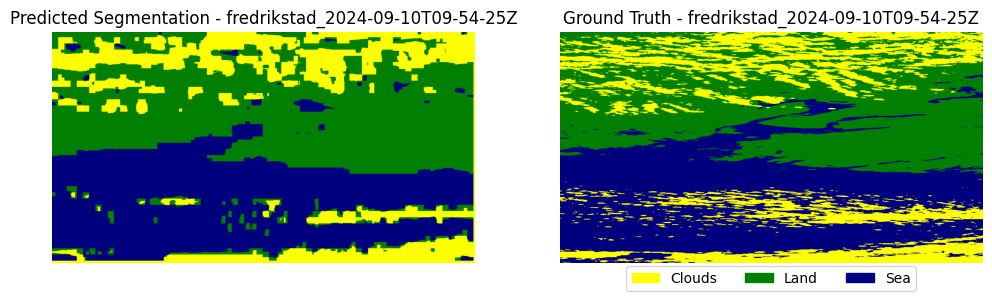

In [18]:

# Define class names and color map (same as original ground truth)
class_names = {1: "Clouds", 2: "Land", 3: "Sea"}
color_map = {
    1: (1, 1, 0),   # Clouds (yellow)
    2: (0, 0.5, 0), # Land (dark green)
    3: (0, 0, 0.5)  # Sea (dark blue)
}

# Convert dictionary to a ListedColormap for Matplotlib
custom_cmap = mcolors.ListedColormap([color_map[i] for i in sorted(color_map.keys())])

# ✅ Pre-load the correct ground truth labels for the test files
testing_label_dict = {
    os.path.basename(fname).replace("-l1a_labels.dat", ""): label
    for fname, label in zip(label_filenames, labels)
}

## Load the best trained model
best_model_path = get_best_model(val_acc_list, val_epoch_list, SAVE_PATH)
print(f"✅ Loading Best Model from: {best_model_path}")

best_model = WaveletCNN(N_PCA, class_nums=NUM_CLASS)
best_model.load_state_dict(torch.load(best_model_path, map_location=device))  # Ensure correct device

## Move model to GPU if available
best_model.to(device)
best_model.eval()  # Set model to evaluation mode

print("✅ Model loaded successfully. Ready for inference!")


# ✅ Process each test image separately
for img_idx, test_img_filename in enumerate(testing_filenames):  
    scene_name = os.path.basename(test_img_filename).replace('-l1b.nc', '')  # Extract scene name
    print(f"\nProcessing Test Image {img_idx + 1}/{len(testing_filenames)} - Scene: {scene_name}")

    # ✅ Load the correct ground truth label file
    if scene_name in testing_label_dict:
        ground_truth = testing_label_dict[scene_name]  # Load the correct label
    else:
        print(f"❌ Warning: No matching ground truth found for {scene_name}")
        continue  # Skip this test case if there's no matching label


    # ✅ Ensure Ground Truth is Unmodified
    print(f"Unique classes in ground truth before plotting: {np.unique(ground_truth)}")

    # ✅ Get the test image data
    test_img = testing_files[img_idx]

    # Create dataset and DataLoader for the current test image
    test_data = TestPatchSet([test_img], patch_size=32, stride=16)
    test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

    ## Initialize storage for predicted patches
    pred_patches = []

    # Process all patches for this test image
    for batch_idx, (data, image_indices) in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Predicting Image {img_idx + 1}"):
        data = data.to(device)  

        # Get model predictions
        out = best_model(data)
        _, pred = torch.max(out, dim=1)  # Get class predictions

        # Convert to numpy and store
        pred_patches.append(pred.detach().cpu().numpy())

    ## Convert predictions into a single array
    pred_patches = np.concatenate(pred_patches, axis=0)

    ## Reconstruct the predicted segmentation map
    original_shape = test_img.shape[:2]  # Extract (H, W) only
    pred_map = reconstruct_image(pred_patches, original_shape, patch_size=32, stride=16)

    ## ✅ Ensure Predictions Contain All Expected Classes
    print(f"Unique classes in prediction before plotting: {np.unique(pred_map)}")

    ## ✅ Create Side-by-Side Comparison Plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Show prediction
    axes[0].imshow(pred_map, cmap=custom_cmap)
    axes[0].set_title(f'Predicted Segmentation - {scene_name}')
    axes[0].axis("off")  

    # Show ground truth
    axes[1].imshow(ground_truth, cmap=custom_cmap)  # ✅ No reshaping, directly plots as loaded
    axes[1].set_title(f'Ground Truth - {scene_name}')
    axes[1].axis("off")  

    # ✅ Create legend
    unique_labels = np.unique(ground_truth)
    patches = [
        mpatches.Patch(color=color_map[label_val], label=class_names.get(label_val, f"Class {label_val}"))
        for label_val in unique_labels
    ]
    axes[1].legend(handles=patches, loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=10)

    # ✅ Show the plot
    plt.show()


## Evaluation

In [16]:
all_true_labels = []
all_pred_labels = []
eval_results = []

for img_idx, test_img_filename in enumerate(testing_filenames):  
    scene_name = os.path.basename(test_img_filename).replace('-l1b.nc', '')  # Extract scene name
    print(f"\nProcessing Test Image {img_idx + 1}/{len(testing_filenames)} - Scene: {scene_name}")

    # ✅ Load the correct ground truth label file
    if scene_name in testing_label_dict:
        ground_truth = testing_label_dict[scene_name]  # Load the correct label
    else:
        print(f"❌ Warning: No matching ground truth found for {scene_name}")
        continue  # Skip this test case if there's no matching label

    ## ✅ Extract valid pixels (ignore background pixels where ground truth is 0)
    test_pred = pred_map[ground_truth != 0]
    test_true = ground_truth[ground_truth != 0]

    ## ✅ Compute metrics for this individual image
    OA = accuracy_score(test_true, test_pred)
    AA = recall_score(test_true, test_pred, average='macro', zero_division=0)
    kappa = cohen_kappa_score(test_true, test_pred)

    unique_classes = np.unique(test_true)

    # ✅ Ensure only present classes are used in target_names
    target_names = [class_names[c] for c in unique_classes if c in class_names]

    # ✅ Compute classification report with dynamically detected classes
    class_report = classification_report(test_true, test_pred, labels=unique_classes, target_names=target_names, digits=4, zero_division=0)


    # ✅ Store the individual results
    eval_results.append({
        "Scene": scene_name,
        "Overall Accuracy": round(OA, 4),
        "Average Accuracy": round(AA, 4),
        "Kappa Score": round(kappa, 4),
        "Classification Report": class_report
    })

    ## ✅ Append results for total evaluation
    all_true_labels.extend(test_true)
    all_pred_labels.extend(test_pred)

    ## ✅ Print individual report
    print(f"\n📌 Evaluation for {scene_name}:")
    print(f"OA: {OA:.4f} | AA: {AA:.4f} | Kappa: {kappa:.4f}")
    print(class_report)
    print("-" * 80)



## ✅ Convert lists to NumPy arrays
all_true_labels = np.array(all_true_labels)
all_pred_labels = np.array(all_pred_labels)

## ✅ Compute overall metrics
OA_total = accuracy_score(all_true_labels, all_pred_labels)
AA_total = recall_score(all_true_labels, all_pred_labels, average='macro', zero_division=0)
kappa_total = cohen_kappa_score(all_true_labels, all_pred_labels)
# ✅ Dynamically get unique class values
unique_classes_overall = np.unique(all_true_labels)

# ✅ Ensure only present classes are used in target_names
target_names_overall = [class_names[c] for c in unique_classes_overall if c in class_names]

# ✅ Compute classification report with dynamically detected classes
overall_class_report = classification_report(all_true_labels, all_pred_labels, labels=unique_classes_overall, target_names=target_names_overall, digits=4, zero_division=0)

## ✅ Store final evaluation
eval_results.append({
    "Scene": "Overall",
    "Overall Accuracy": round(OA_total, 4),
    "Average Accuracy": round(AA_total, 4),
    "Kappa Score": round(kappa_total, 4),
    "Classification Report": overall_class_report
})

## ✅ Print overall report
print("\n📊 Overall Evaluation Across All Predicted Images:")
print(f"Overall Accuracy: {OA_total:.4f} | Average Accuracy: {AA_total:.4f} | Kappa: {kappa_total:.4f}")
print(overall_class_report)







Processing Test Image 1/4 - Scene: adriatic_2024-07-18T08-53-45Z

📌 Evaluation for adriatic_2024-07-18T08-53-45Z:
OA: 0.1168 | AA: 0.2573 | Kappa: 0.0030
              precision    recall  f1-score   support

      Clouds     0.0032    0.6551    0.0064      1360
        Land     0.3143    0.3742    0.3416    201405
         Sea     0.0000    0.0000    0.0000    450251

   micro avg     0.1472    0.1168    0.1302    653016
   macro avg     0.1058    0.3431    0.1160    653016
weighted avg     0.0970    0.1168    0.1054    653016

--------------------------------------------------------------------------------

Processing Test Image 2/4 - Scene: aegean_2024-08-22T08-41-46Z

📌 Evaluation for aegean_2024-08-22T08-41-46Z:
OA: 0.0373 | AA: 0.1547 | Kappa: 0.0075
              precision    recall  f1-score   support

      Clouds     0.0015    0.1402    0.0030      2967
        Land     0.0998    0.4785    0.1652     50020
         Sea     0.0000    0.0000    0.0000    600029

   micro avg  